In [51]:
!pip install xlrd

In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = (os.path.join(dirname, filename))
        df = pd.read_excel(path)
        df.to_csv(os.path.join('/kaggle/working/', filename.replace('.xls', '.csv')))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Read the frame

In [59]:
df = pd.read_csv('/kaggle/working/2024-05-17(16-57-14).csv')
df

,Unnamed: 0,x,y,t
0,0,0.05560,0.000122,-0.005
1,1,0.07315,0.000122,0.005
2,2,0.08830,0.002122,0.015
3,3,0.10735,0.005072,0.025
4,4,0.12640,0.008273,0.035
5,5,0.14310,0.013122,0.045
6,6,0.16015,0.019072,0.055
7,7,0.17720,0.026023,0.065
8,8,0.19580,0.032972,0.075
9,9,0.21305,0.042372,0.085


## Plot the trace

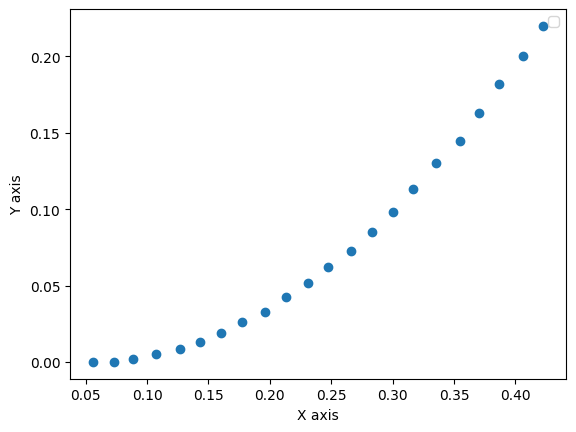

In [54]:
import matplotlib.pyplot as plt

plt.scatter(df['x'], df['y'])
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.legend()
plt.show()

## Use torch to train

In [62]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.x = df['x'].to_numpy()
        self.y = df['y'].to_numpy()
        self.t = df['t'].to_numpy()
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, id):
        src = torch.tensor([self.t[id] ** 2, self.t[id]], dtype=torch.float32)
        dest = torch.tensor([self.x[id]], dtype=torch.float32)
        return src, dest

dataset = CustomDataset(df)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(2, 1)
    
    def forward(self, x):
        return self.fc(x)

model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train(model, dataloader, optimizer, criterion):
    epochs = 10
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(tqdm(dataloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    print(model.state_dict())

train(model, data_loader, optimizer, criterion)

100%|██████████| 1/1 [00:00<00:00, 305.69it/s]


Epoch 1, Loss: 0.4797787666320801


100%|██████████| 1/1 [00:00<00:00, 321.48it/s]


Epoch 2, Loss: 0.4645023047924042


100%|██████████| 1/1 [00:00<00:00, 314.68it/s]


Epoch 3, Loss: 0.4494820535182953


100%|██████████| 1/1 [00:00<00:00, 333.97it/s]


Epoch 4, Loss: 0.43472230434417725


100%|██████████| 1/1 [00:00<00:00, 353.95it/s]


Epoch 5, Loss: 0.4202270209789276


100%|██████████| 1/1 [00:00<00:00, 297.43it/s]


Epoch 6, Loss: 0.4060001075267792


100%|██████████| 1/1 [00:00<00:00, 253.54it/s]


Epoch 7, Loss: 0.3920450806617737


100%|██████████| 1/1 [00:00<00:00, 425.86it/s]


Epoch 8, Loss: 0.37836527824401855


100%|██████████| 1/1 [00:00<00:00, 403.65it/s]


Epoch 9, Loss: 0.3649636209011078


100%|██████████| 1/1 [00:00<00:00, 334.26it/s]

Epoch 10, Loss: 0.3518429398536682
OrderedDict([('fc.weight', tensor([[-0.2674,  0.1648]], device='cuda:0')), ('fc.bias', tensor([-0.3465], device='cuda:0'))])


## Use scipy & sklearn to analyze the data

Due to some problems with `torch`, using scikit to analyze the data is better.

In [ ]:
import scikit